In [1]:
gROOT->ProcessLine(".L /home/rj/app/lib/libRadioScatter.so");
gROOT->ProcessLine("#include </home/rj/app/include/RadioScatter/RadioScatter.hh>");
gROOT->ProcessLine("#include </home/rj/app/include/RadioScatter/RSEventSummary.hh>");
gROOT->ProcessLine("#include </home/rj/app/include/RadioScatter/RadioScatterEvent.hh>");
gROOT->ProcessLine("#include </home/rj/app/include/RadioScatter/TUtilRadioScatter.hh>");

In [2]:
int glob_to_y(TH2* hist, int global){
    int x_bins = hist->GetNbinsX();
    int temp = global / (x_bins + 2);
    // x bin value is global % the total number of x bins (GetNbinsX doesn't count either buffer bin)
    return temp;
}

In [3]:
int glob_to_x(TH2* hist, int global){
    int x_bins = hist->GetNbinsX();
    int temp = global % (x_bins + 2);
    // x bin value is global % the total number of x bins (GetNbinsX doesn't count either buffer bin)
    return temp;
}

In [4]:
TGraph* makegraph(int t_window, TH2D *spec){
    int NumFreqBins = spec->GetNbinsX();
    int NumIntensBins = spec->GetNbinsY();
    int binmax = spec->GetMaximumBin(); // bin number of max intensity
    double *pows = new double[NumFreqBins]; // array of frequencies
    double *ybin = new double[NumFreqBins]; // array of y bin numbers
    double_t iterator = 0; // iterator for the for loop
    int i = t_window - 390; // time bin number of the max intensity
    for(int j = 0; j < spec->GetNbinsY(); j++){
        if(j==0){pows[j]=0;}
        else{pows[j]=spec->GetBinContent(i,j);}
        ybin[j] = j*0.015625*1000; // y bin number x YBinWidth * 1000MHz/GHz
        iterator ++;
    }
    TGraph *gr = new TGraph(NumFreqBins, ybin, pows);
    return gr;
}

In [5]:
double* power_generator(TH2D *spec, double *pows_in){
    int NumFreqBins = spec->GetNbinsX();
    int NumIntensBins = spec->GetNbinsY();
    int binmax = spec->GetMaximumBin(); // bin number of max intensity
    double *pows = new double[NumFreqBins]; // array of frequencies
    double *retpows = new double[NumFreqBins]; // array of frequencies
    double *ybin = new double[NumFreqBins]; // array of y bin numbers
    double_t iterator = 0; // iterator for the for loop
//    int i = binmax - 390; // time bin number of the max intensity
    int i = 460 - 390;
    for(int j = 0; j < 32; j++){
        if(j==0){pows[j]=0;}
//        else{pows[j]=spec->GetBinContent(i,j) + pows_in[j];
            else{pows[j]=spec->GetBinContent(i,j);
        }
        ybin[j] = j*0.015625*1000; // y bin number x YBinWidth * 1000MHz/GHz
        iterator ++;
    }
    // loop over each entry in pows, add the value of pows_in, then return pows
    for (int k = 0; k < NumFreqBins; k++){
        retpows[k] = pows[k] + 1*pows_in[k];
        if (retpows[k] > 1*pow(10,-18)){
            cout << "pows[" << k << "] = " << pows[k] << " retpows[" << k << "] = " << retpows[k] << endl;
        }
    }
    return retpows;
}

In [6]:
TString infile = "/home/rj/RadioScatter/outputfiles/multiscat_0GHz_10W_10ns.root";
//    TString infile = "/home/rj/RadioScatter/doc/multiscat_0MHz_10W_10ns.root";
auto ff = TFile::Open(infile, "READ");
int rxindex = 0;
int txindex = 0;
int antenna = 0;
int entry = 0;
auto tree=(TTree*)ff->Get("tree");    

TCanvas *c1 = new TCanvas("c1", "c1", 800, 600);
c1->Divide(2, 2);
//    c1->SetWindowSize(1200, 1200);
c1->SetWindowSize(1200, 800);
gPad->SetLeftMargin(.1);
gPad->SetBottomMargin(0);
c1->cd(1);
// c1->cd(1)->SetLeftMargin(.15);
// c1->cd(1)->SetRightMargin(.2);
// c1->cd(2)->SetLeftMargin(.15);
// c1->cd(3)->SetLeftMargin(.15);
// c1->cd(3)->SetRightMargin(.2);
// c1->cd(4)->SetLeftMargin(.15);

auto event = new RadioScatterEvent();
tree->SetBranchAddress("event", &event);

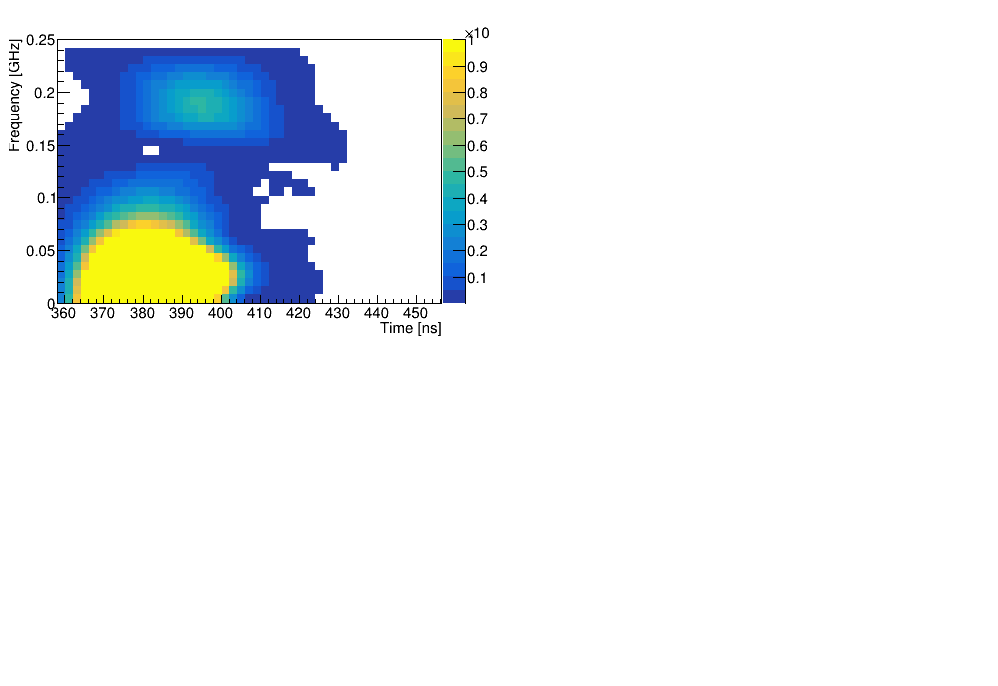

In [7]:
int entries = tree->GetEntries();
tree->GetEntry(entry); // get the first entry
auto evG = event->getGraph(rxindex, txindex); // generates graph evG
TUtilRadioScatter::titles(evG, "", "Time [ns]", "V");
TUtilRadioScatter::style(evG, kBlack, 1, 1);
TUtilRadioScatter::xrange(evG, evG->GetX()[0], evG->GetX()[evG->GetN() - 1]);
int bins = 32, overlap = 31;
auto spec = TUtilRadioScatter::FFT::spectrogram(evG, bins, overlap, bins * 2, 2, 0, 0, .2); // generates spectrogram spec
c1->SetLogy(0); // set y axis to linear
c1->cd(1); //moves to canvas 1, upper left
c1->cd(1)->SetLogy(0); // set y axis to linear
spec->SetStats(0); // removes stats box
spec->GetYaxis()->SetRangeUser(0,.25);
spec->GetZaxis()->SetRangeUser(1*pow(10,-18), 1*pow(10,-15));
spec->Draw("colz"); // draws spectrogram to canvas 1 upper left

auto mg = new TMultiGraph(); // creates a multigraph
c1->cd(2)->SetLogy(1); // set y axis to logarithmic
c1->Draw();


In [11]:
int NumFreqBins=spec->GetNbinsX();
int NumTimeBins=spec->GetNbinsY();
double *pows = new double[NumFreqBins];
double *ybin = new double[NumFreqBins];
double_t iterator = 0;
int spec_start_time; // time at which the spectrogram "spec" starts
    if(fmod(evG->GetX()[0], 1) >=.5){ // C++ rounds down for all numbers, so
        spec_start_time = evG->GetX()[0] + 1; // if the decimal is >= .5, add 1 to the integer part
    }
    else{
        spec_start_time = evG->GetX()[0]; // otherwise, just use the integer part
    }
int binmax = spec->GetMaximumBin(); // bin number of max intensity
int xmax = glob_to_x(spec, binmax); // x bin number of max intensity
cout << spec->GetNbinsX() << " x " << spec->GetNbinsY() << " bins" << endl;
cout << "max, global bin number = " << binmax << endl;
cout << "max, x bin number = " << xmax << endl;
cout << "start time = " << spec_start_time << endl;
cout << "max time = " << spec_start_time + xmax << endl;
cout << "NumFreqBins = " << NumFreqBins << endl;
cout << "NumTimeBins = " << NumTimeBins << endl;



int i = xmax;
for(int j = 0; j < spec->GetNbinsY(); j++){
    if(j==0){
        pows[j]=0;
    }
    else{
        pows[j]=spec->GetBinContent(i,j);
    }
    ybin[j] = j*.0625*1000*2.5; // y bin number x .2GHz/32bins * 1000MHz/GHz * 2.5 to account for overlap
    iterator ++;
}

double max;
int maxj;
for(int j = 0; j < spec->GetNbinsY(); j++){
    if(j == 0){
        max = 0.0;
    }
    if(pows[j] > max){
        maxj = j*.0625*1000*2.5;
        max = pows[j];
    } Generating stack trace...
 0x00007f0e8a34b210 in TClass::SetUnloaded() + 0x130 from /home/rj/root/lib/libCore.so.6.26
 0x00007f0e8a2f41c4 in ROOT::RemoveClass(char const*) + 0x64 from /home/rj/root/lib/libCor
    iterator ++;
}
cout << max << endl;
cout << maxj << endl;


49 x 64 bins
max, global bin number = 166
max, x bin number = 13
start time = 358
max time = 371
NumFreqBins = 49
NumTimeBins = 64
5.79366e-15
468


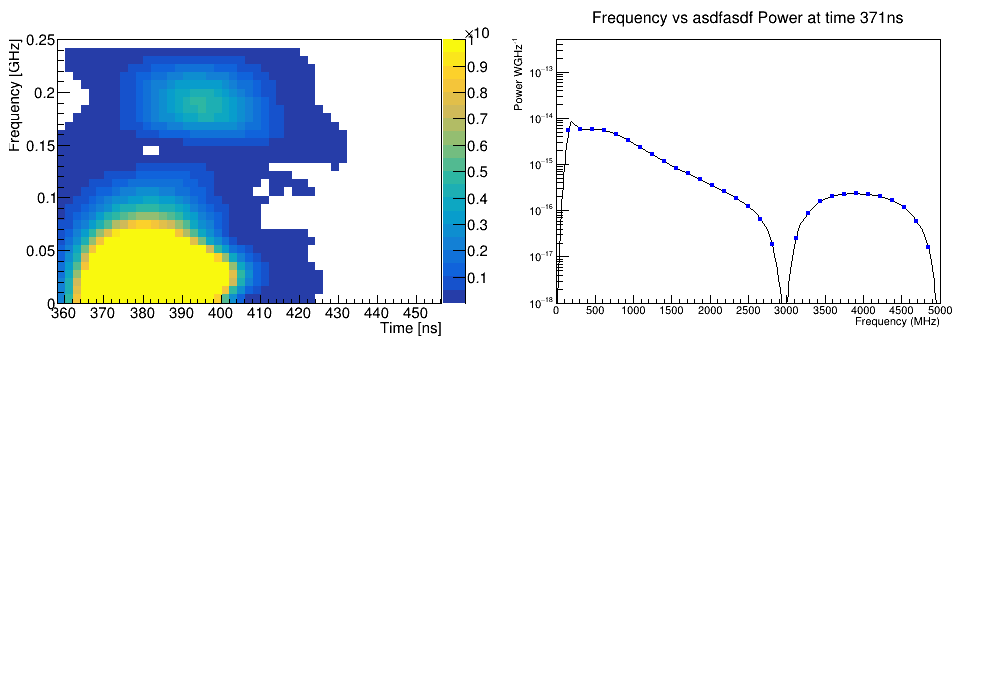

In [12]:
TGraph *gr = new TGraph(NumFreqBins, ybin, pows);
//    gr->GetYaxis()->SetRangeUser(1*pow(10,-18), 1*pow(10,-8));
    gr->GetYaxis()->SetRangeUser(1*pow(10,-18), 5*pow(10,-13));
//    gr->GetYaxis()->SetLimits(1*pow(10,-18), 1*pow(10,-15));
    gr->SetMarkerColor(4);
    gr->SetMarkerSize(.5);
    gr->SetMarkerStyle(21);
//    gr->GetXaxis()->SetLimits(0,200);
    gr->GetXaxis()->SetLimits(0,5000);
    gr->SetTitle(Form("Frequency vs asdfasdf Power at time %dns", (i + spec_start_time))); // set title of graph with the time of maximum intensity
    gr->GetXaxis()->SetTitle("Frequency (MHz)");
    gr->GetYaxis()->SetTitle("Power WGHz^{-1}");
gr->Draw("ACP");
c1->Draw();

In [8]:
double *newpows = new double[entries];

In [ ]:
TGraph *gr1 = new TGraph(NumFreqBins, ybin, newpows);
gr1->GetYaxis()->SetRangeUser(1*pow(10,-18), 1*pow(10,-9));
//    gr1->GetYaxis()->SetLimits(1*pow(10,-18), 1*pow(10,-15));
gr1->SetMarkerColor(4);
gr1->SetMarkerSize(.5);
gr1->SetMarkerStyle(21);
gr1->GetXaxis()->SetLimits(0,5000);
gr1->SetTitle("Frequency vs Power summed over all events (0-5GHz)");
gr1->GetXaxis()->SetTitle("Frequency (MHz)");
gr1->GetYaxis()->SetTitle("Power WGHz^{-1}");
gr1->Draw("ACP");